# Problem 1

In [27]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [28]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms)

## 1.1.1

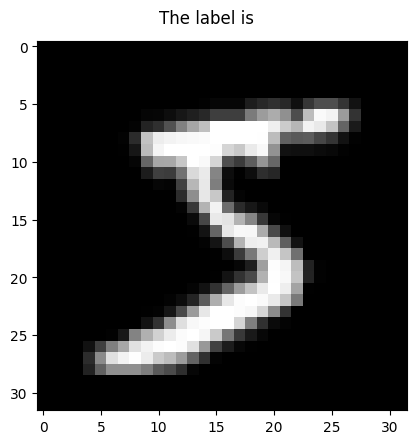

In [29]:
# Get first image and label
image, label = train_dataset[0]

# I converted tensor image to numpy for better visualization
image = image.squeeze(0)

plt.imshow(image, cmap='gray')
plt.text(10, -2, 'The label is ' , fontsize=12, color='black')
plt.show()

In [30]:
# hyper parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

## 1.1.2

In [31]:
# define the data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True) # shuffle should be true for better training

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False) # don't need to shuffle for validation

## 1.1.3

In [32]:
def train(train_loader, model, criterion, optimizer):
    '''
    Train one epoch.
    '''

    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        # resetting the gradients
        optimizer.zero_grad()


        # Forward pass
        y_hat, _ = model(X)
        # compute loss
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        # compute gradients and update weights accordingly
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

## 1.1.4

In [33]:
def validate(valid_loader, model, criterion):
    '''
    Function for the validation step of the training loop.
    Returns the model and the loss on the test set.
    '''

    # set model in evaluation mode
    model.eval()
    running_loss = 0


    for X, y_true in valid_loader:

      # Forward pass and record loss
      # obtain predictions
      y_hat, _ = model(X)
      # compute loss
      loss = criterion(y_hat, y_true)

      running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss

In [34]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, print_every=1):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader,)
            train_accs.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader)
            valid_accs.append(valid_acc)

            print(f'{datetime.now().time().replace(microsecond=0)} '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    performance = {
        'train_losses':train_losses,
        'valid_losses': valid_losses,
        'train_acc': train_accs,
        'valid_acc':valid_accs
    }

    return model, optimizer, performance

## 1.1.5

In [35]:
def get_accuracy(model, data_loader):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    # set model in evaluation mode
    model.eval()
    for X, y_true in data_loader:

      # obtain predictions
      y_hat, _ = model(X)
      # obtain predicted class
      predicted_labels = torch.argmax(y_hat, dim=1)

      n += y_true.size(0)
      correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n



def plot_performance(performance):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn-v0_8')

    fig, ax = plt.subplots(1, 2, figsize = (16, 4.5))
    for key, value in performance.items():
        if 'loss' in key:
            ax[0].plot(value, label=key)
        else:
            ax[1].plot(value, label=key)
    ax[0].set(title="Loss  over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].set(title="accuracy over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax[0].legend()
    ax[1].legend()
    plt.show()

    # change the plot style to default
    plt.style.use('default')

## 1.2.1

In [36]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        # Convolutional layers
        # 28x28x6
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        # 14x14x6
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        # 10x10x16
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        # 5x5x16
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        # 1x1x120
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)

        # Fully connected layers
        # 120 -> 84
        self.fc1 = nn.Linear(120, 84)
        # 84 -> 10 (final output classes)
        self.fc2 = nn.Linear(84, n_classes)

        # defining classifier
        self.classifier = self.fc2


    def forward(self, x):

        # using tanh activation as mentioned in homework document
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)
        x = torch.tanh(self.conv3(x))

        # flatten before fully connected layers
        x = x.view(x.size(0), -1)
        x = torch.tanh(self.fc1(x))

        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

## 1.2.2

In [37]:
class MLP(nn.Module):

    def __init__(self, layers):
        super(MLP, self).__init__()

        # initialize ModuleList
        self.layers = nn.ModuleList()

        # create fully connected layers
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, x):

        # flatten input tensor
        x = x.view(x.size(0), -1)

        # apply tanh activation to all hidden layers except last one
        for layer in self.layers[:-1]:
            x = F.tanh(layer(x))

        # final layer
        logits = self.layers[-1](x) # no activation
        probs = F.softmax(logits, dim=1)
        return logits, probs

## 1.3.1

In [38]:
torch.manual_seed(RANDOM_SEED)
model = LeNet5(N_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [39]:
model, optimizer, performance_1 = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS)

02:25:06 Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
02:25:56 Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
02:26:48 Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
02:27:40 Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
02:28:31 Epoch: 4	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.25	Valid accuracy: 98.75
02:29:20 Epoch: 5	Train loss: 0.0299	Valid loss: 0.0422	Train accuracy: 99.41	Valid accuracy: 98.66
02:30:09 Epoch: 6	Train loss: 0.0241	Valid loss: 0.0409	Train accuracy: 99.47	Valid accuracy: 98.70
02:30:58 Epoch: 7	Train loss: 0.0228	Valid loss: 0.0418	Train accuracy: 99.57	Valid accuracy: 98.69
02:31:47 Epoch: 8	Train loss: 0.0186	Valid loss: 0.0447	Train accuracy: 99.53	Valid accuracy: 98.70
02:32:36 Epoch: 9	Train loss: 0.0161	Valid loss: 0.0468	Train accuracy: 99.64	Valid accuracy: 98.70


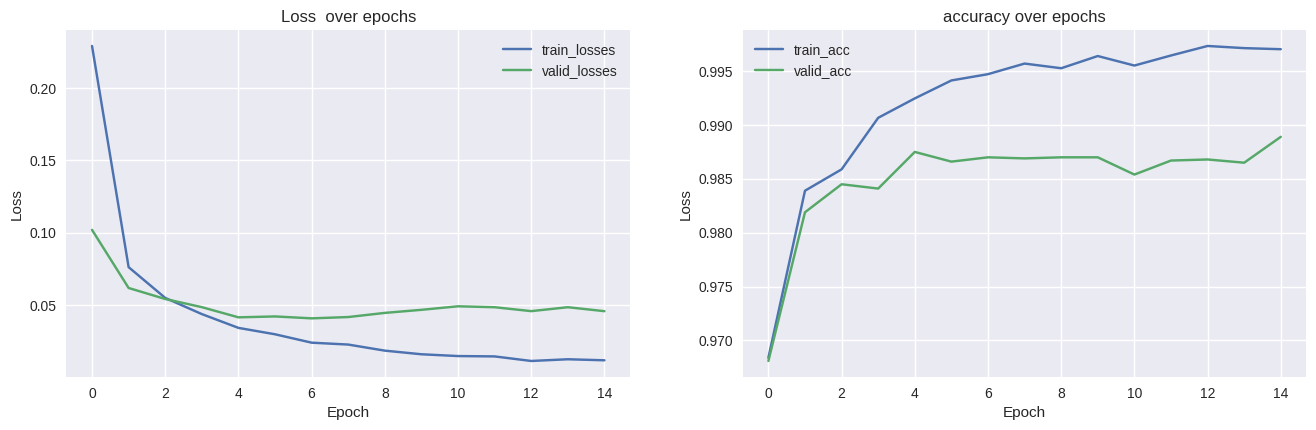

In [40]:
plot_performance(performance_1)

Over each epoch, the train and validation loss mainly seem to decrease, while train and validation accuracy mainly seem to increase. The biggest increase in accuracy and biggest decrease in loss occurred from epoch 0 to epoch 1. From epoch 3 to epoch 14, the accuracy remained steady at around 99%, and at epoch 0 the accuracy was around 96%, which shows how quickly the model improved in the first half. From the graphs, we can see that the training loss decreases consistently, showing that the model is learning well, but since the validation loss stabilizes towards the end, some overfitting may be happening. We can also see that the training accuracy reaches 99.7%, meaning that the model is fitting very well to the training data, but the validation accuracy stabilizes around 98%, which falls short compared to the training accuracy.

## 1.3.2

In [41]:
torch.manual_seed(RANDOM_SEED)
layers = [1024, 256, 64, 16, N_CLASSES]
model = MLP(layers)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [42]:
model, optimizer, performance_2 = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS)

02:37:13 Epoch: 0	Train loss: 0.3575	Valid loss: 0.1636	Train accuracy: 95.61	Valid accuracy: 95.23
02:37:45 Epoch: 1	Train loss: 0.1307	Valid loss: 0.1195	Train accuracy: 97.27	Valid accuracy: 96.38
02:38:18 Epoch: 2	Train loss: 0.0927	Valid loss: 0.1016	Train accuracy: 97.93	Valid accuracy: 96.97
02:38:50 Epoch: 3	Train loss: 0.0725	Valid loss: 0.0896	Train accuracy: 98.21	Valid accuracy: 97.26
02:39:23 Epoch: 4	Train loss: 0.0592	Valid loss: 0.0844	Train accuracy: 98.41	Valid accuracy: 97.45
02:39:55 Epoch: 5	Train loss: 0.0514	Valid loss: 0.0973	Train accuracy: 98.33	Valid accuracy: 97.14
02:40:26 Epoch: 6	Train loss: 0.0433	Valid loss: 0.0845	Train accuracy: 98.80	Valid accuracy: 97.35
02:40:57 Epoch: 7	Train loss: 0.0380	Valid loss: 0.0728	Train accuracy: 99.25	Valid accuracy: 97.79
02:41:29 Epoch: 8	Train loss: 0.0328	Valid loss: 0.0822	Train accuracy: 99.25	Valid accuracy: 97.76
02:42:01 Epoch: 9	Train loss: 0.0324	Valid loss: 0.0801	Train accuracy: 99.42	Valid accuracy: 97.82


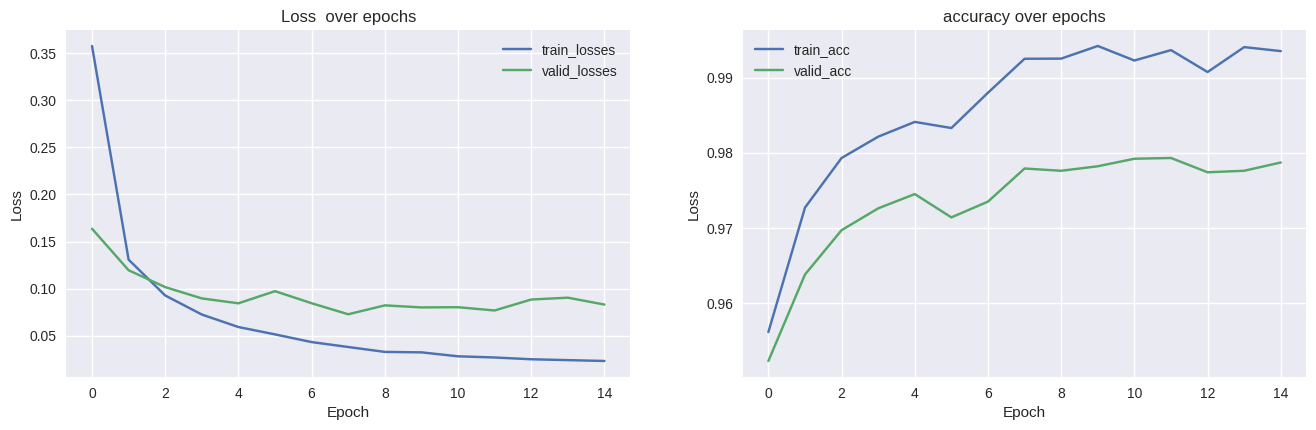

In [43]:
plot_performance(performance_2)

Over each epoch, the train and validation loss mainly seem to decrease, while train and validation accuracy mainly seem to increase. The biggest increase in accuracy and biggest decrease in loss occurred from epoch 0 to epoch 1. From epoch 7 to epoch 14, the accuracy remained steady at around 99%, and at epoch 0 the accuracy was around 95%, which shows that the model improved more during the second half of training compared to the first half. From the graphs, we can see that the training loss decreases consistently, showing that the model is learning well, but since the validation loss stabilizes towards the end, some overfitting may be happening. We can also see that the training accuracy reaches 99.35%, meaning that the model is fitting very well to the training data, but the validation accuracy stabilizes around 97%, which falls short compared to the training accuracy.

# 1.4.1

## Conv1 (Conv2d):

Input Channels: 1

Output Channels: 6

Kernel size: 5 × 5

Weights: 1 × 5 × 5 × 6 = 150

Biases: 6

Total Parameters: 150 + 6 = 156

## Conv2 (Conv2d):

Input Channels: 6

Output Channels: 16

Kernel Size: 5 × 5

Weights: 6 × 5 × 5 × 16 = 2,400

Biases: 16

Total Parameters: 2,400 + 16 = 2,416

## Conv3 (Conv2d):

Input Channels: 16

Output Channels: 120

Kernel size: 5 × 5

Weights: 16 × 5 × 5 × 120 = 48,000

Biases: 120

Total Parameters: 48,000 + 120 = 48,120

## Fully connected (fc1):

Input: 120 neurons

Output: 84 neurons

Weights: 120 × 84 = 10,080

Biases: 84

Total Parameters: 10,080 + 84 = 10,164

## Fully connected (fc2):

Input: 84 neurons

Output: 10 classes

Weights: 84 × 10 = 840

Biases: 10

Total Parameters: 840 + 10 = 850

## Total Number of Trainable Parameters for LeNet:

156 + 2,416 + 48,120 + 10,164 + 850 = 61,706 parameters

# 1.4.2

## First layer (Input to Hidden Layer 1):

Number of weights: 1024 × 256 = 262,144

Number of biases: 256

Total parameters: 262,144 + 256 = 262,400

## Second layer (Hidden Layer 1 to Hidden Layer 2):

Number of weights: 256 × 64 = 16,384

Number of biases: 64

Total parameters for this layer: 16,384 + 64 = 16,448

## Third layer (Hidden Layer 2 to Hidden Layer 3):

Number of weights: 64 × 16 = 1,024

Number of biases: 16

Total parameters: 1,024 + 16 = 1,040

## Fourth layer (Hidden Layer 3 to Output):

Number of weights: 16 × 10 = 160

Number of biases: 10

Total parameters: 160 + 10 = 170

## Total Number of Trainable Parameters for MLP:

262,400 + 16,448 + 1,040 + 170 = 280,058 parameters

# 1.4.3

LeNet has a better performance in terms of prediction accuracy on the test data compared to MLP. This is because LeNet is a CNN while MLP is a Fully Connected Network. LeNet can learn local patterns like edges, textures, and shapes, which is useful for tasks like image classification. LeNet also uses pooling layers, which helps in overfitting, and LeNet can recognize features regardless of where they are in the image. MLP considers image pixels as independent, making it harder for the model to learn structures in image data. MLPs do not use pooling layers and can be very large in nature, so they may not generalize well to image tasks like MNIST, and therefore MLPs struggle more with image data compared to CNNs.

# Statement of Collaboration:

I worked on this assignment alone and used all resources available from Canvas to complete this assignment.